<a href="https://colab.research.google.com/github/rakibulhaque9954/Emotion-model-sec-15/blob/main/Emotion_detection_model(sec_15).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libararies and Installations

## Imports

In [8]:
import tensorflow as tf
import numpy as np
# import wandb
import matplotlib.pyplot as plt
from keras.layers import InputLayer, Conv2D, BatchNormalization, Flatten, Dense, MaxPool2D, Dropout, Rescaling, RandomRotation, RandomFlip, RandomContrast
from keras.regularizers import L2
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
# import importlib

# tfp = importlib.import_module("tensorflow_probability") # another way to import libraries
import tensorflow_probability as tfp
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2
# from tensorflow.train import BytesList, Floatlist, Int64List
# from tensorflow.train import Example, Features, Feature

In [9]:
 !pip3 install kaggle





In [10]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [11]:
# giving user raed and write rights in kaggle file
!chmod 600 ~/.kaggle/kaggle.json


In [12]:
# copying api command of dataset from kaggle and downloading
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 307M/309M [00:08<00:00, 37.4MB/s]
100% 309M/309M [00:08<00:00, 37.5MB/s]


In [ ]:
!unzip 'human-emotions-datasethes.zip' -d '/content/dataset'

# Data Preprocessing

In [134]:
train_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/train'
# using test dataset as val dataset
validation_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'sad'] # keep the order of the classses for consistency

In [135]:
CONFIGURATION =  {
    'BATCH_SIZE' : 32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE': 0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1': 1024,
    'N_DENSE_2': 128,
    'NUM_CLASSES': 3

}

In [136]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 6799 files belonging to 3 classes.


In [137]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 2278 files belonging to 3 classes.


In [138]:
for i in val_dataset.take(1):
  # visualizing labels and their respective values
  print(i) # binary vectors or int class depending on the mode

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

# Dataset Visualization

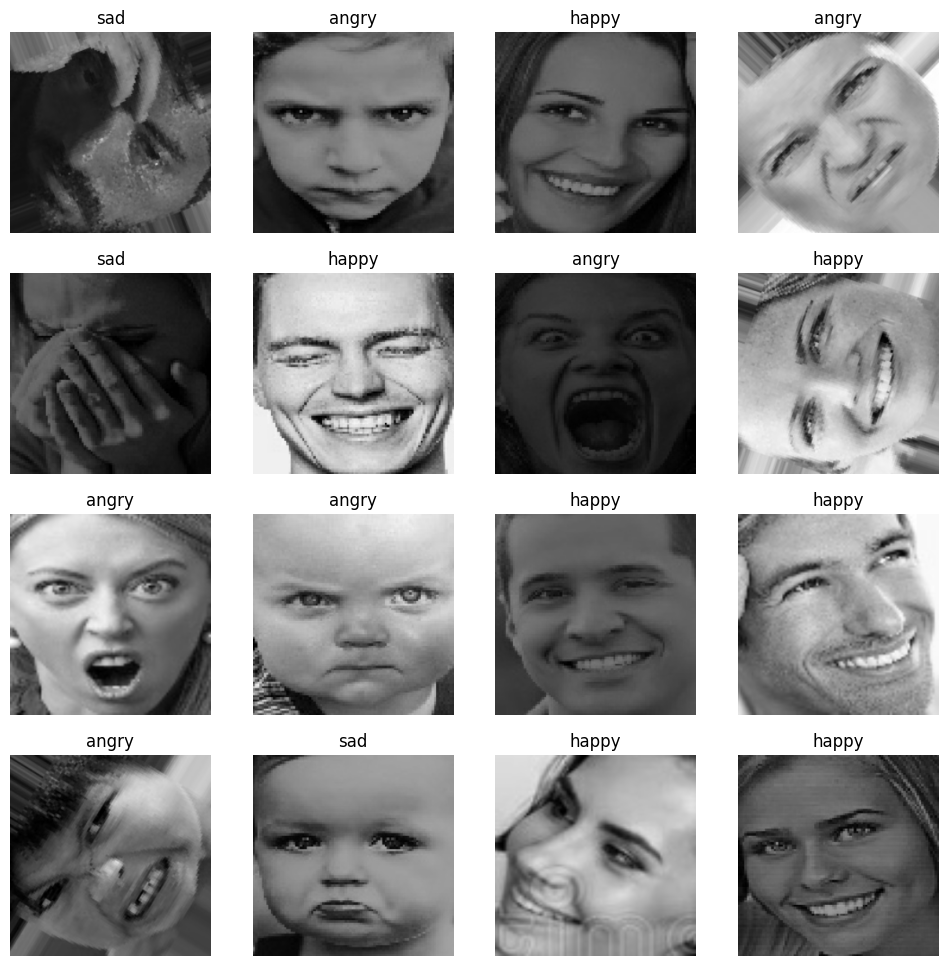

In [18]:
plt.figure(figsize = (12, 12))
for images, labels in train_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(CLASS_NAMES[label_index])
    # plt.title((tf.argmax(labels[i])).numpy()) printing when printing the index value of classes when using bianry vector mode
    ax.axis('off')

# Data Augmentation



In [150]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor= (-0.025, 0.025)), # rotation is limited
    RandomFlip(mode= 'horizontal'),
    RandomContrast(factor= 0.1)

])

In [151]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

## Cutmix augmentation

In [152]:
def box(lamda):
  # lamda = tfp.distributions.Beta(0.2, 0.2) # generates random values based on probabilites and proportions
  # lamda = lamda.sample(1)[0]

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  r_y = tf.clip_by_value(r_y - r_h // 2, 0, CONFIGURATION['IM_SIZE']) # this method_makes sure that the value stays only between 0, IM_SIZE not negative

  x_b_r = tf.clip_by_value(r_x + r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, CONFIGURATION['IM_SIZE']) # x_b_r is x bottom right and clip is to make the sure value is always inside the image bounds

  r_w = x_b_r - r_x
  if (r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [153]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2) # generates random values based on probabilites and proportions
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda) # calling the function that creats random box in the image

  crop_1 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  crop_2 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  image = image_1 - pad_2 + pad_1

  # for label
  lamda = tf.cast(1 - (r_w * r_h) / (CONFIGURATION['IM_SIZE'] * CONFIGURATION['IM_SIZE']) , dtype= tf.float32)
  label = lamda* tf.cast(label_1, dtype = tf.float32) + (1-lamda)* tf.cast(label_2, dtype = tf.float32)

  return image, label

In [154]:
# data preparation for cutmix
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls= tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls= tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [155]:
# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
#     )

# Dataset Preparation

In [156]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)
# using cutmix thats why in comments

In [157]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [158]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    tf.keras.layers.Rescaling(1./255)
]) # its good for deployment and prevents extra steps

# Modeling

## Transfer Learning with EfficientNet

In [142]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False, # we are not training or fine-tuning the top part/ feature extractor part
    weights='imagenet',
    input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)
)

In [143]:
# specifying the weights in the upper part to be untrainable as we will levergaing those weights, freezing our model
backbone.trainable = False # crucial step

In [144]:
# finetuning the last layers to fit the cause of the emotion dataset

from keras.layers import GlobalAveragePooling2D, Dense
from keras.api._v2.keras.layers import Input
from keras.models import Model

x = backbone.output
x =  GlobalAveragePooling2D()(x)

x = Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu')(x)

output = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')(x)
model = Model(backbone.inputs, output)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_15 (Rescaling)    (None, 256, 256, 3)          0         ['input_18[0][0]']            
                                                                                                  
 normalization_5 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_15[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_16 (Rescaling)    (None, 256, 256, 3)          0         ['normalization_5[0][0]'

## Finetuning EfficientNet

In [ ]:
backbone.trainable = True # updating the weights

In [ ]:
from keras.models import Model
input =  Input(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3))
x = backbone(input, training = False) # not allowing it to use the same mean and variance used for training
x = GlobalAveragePooling2D()(x)


x = Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu')(x)

output = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'relu')(x)

fine_tuned_model = Model(input, output)


# Visualizing the Hidden Layers or the BlackBox

<p>Using the VGG16 Model we will visualize each layers and their outputs, basically what goes on inside the layers after the images are passed and their feature maps, we will see what the layers are seeing and adjusting accordingly</p>

## VGG16 Model

In [31]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)
)

In [32]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [41]:
def is_conv(layer_name): # taking particular layers
  if 'conv' in layer_name:
    return True
  else:
    return False

In [54]:
from keras.models import Model

feature_maps = [layer.output for layer in vgg_backbone.layers[1:] ]#if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [55]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/119197.jpg')

desired_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])
resized_image = cv2.resize(test_image, desired_size)

# Convert the resized image to a tensor
image_tensor = tf.constant(resized_image, dtype=tf.float32)

# Expand the dimensions to create a batch with a single image
image_tensor = tf.expand_dims(image_tensor, axis=0)

# Make predictions
f_maps = feature_map_model.predict(image_tensor)



1/1 [==============================] - 0s 145ms/step


In [56]:
print(len(f_maps))

18


In [57]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 8, 8, 512)


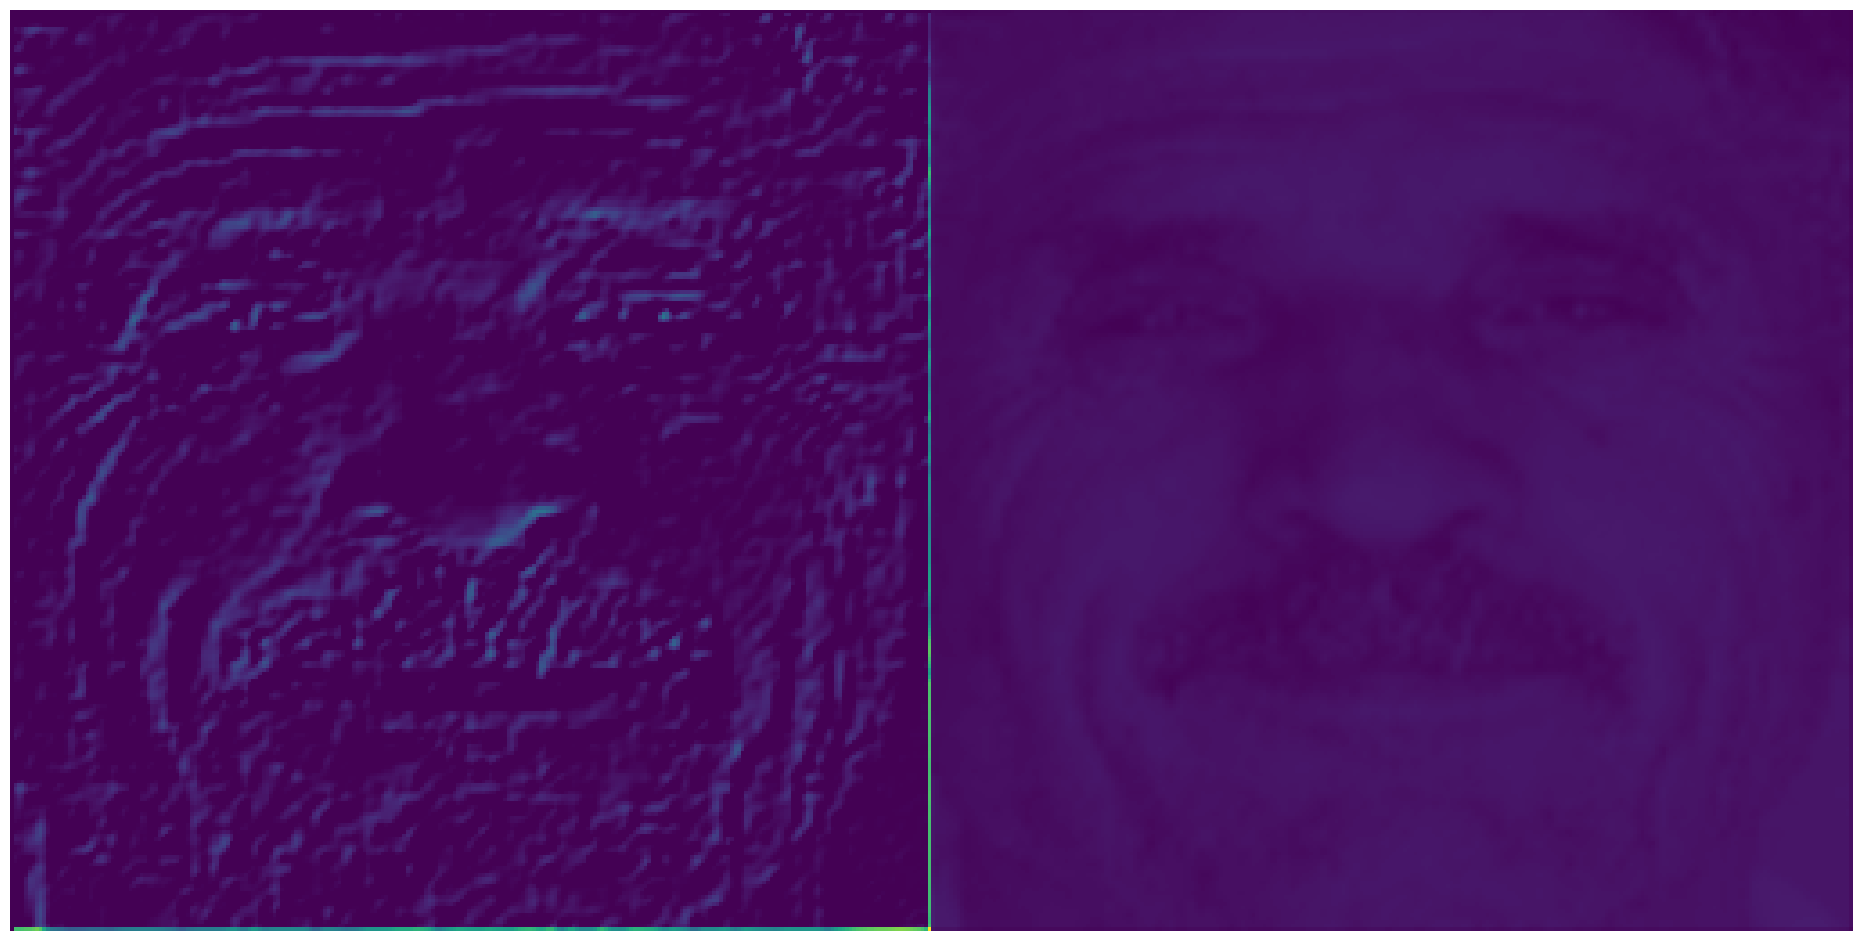

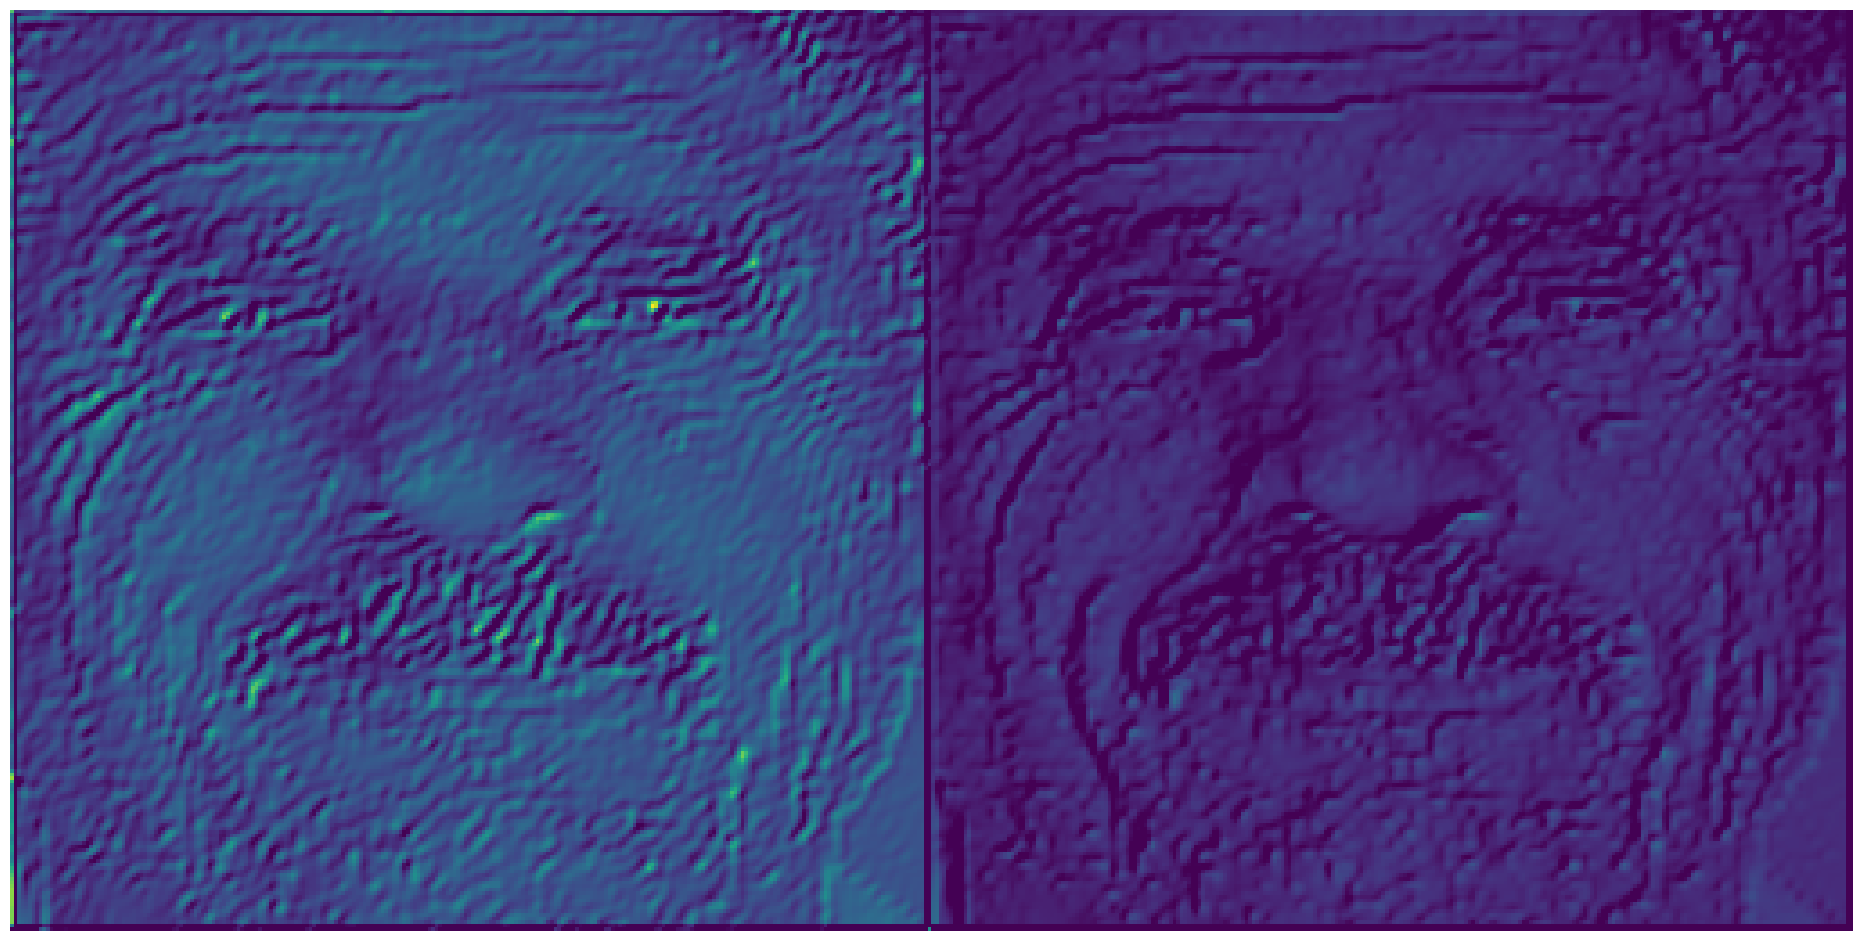

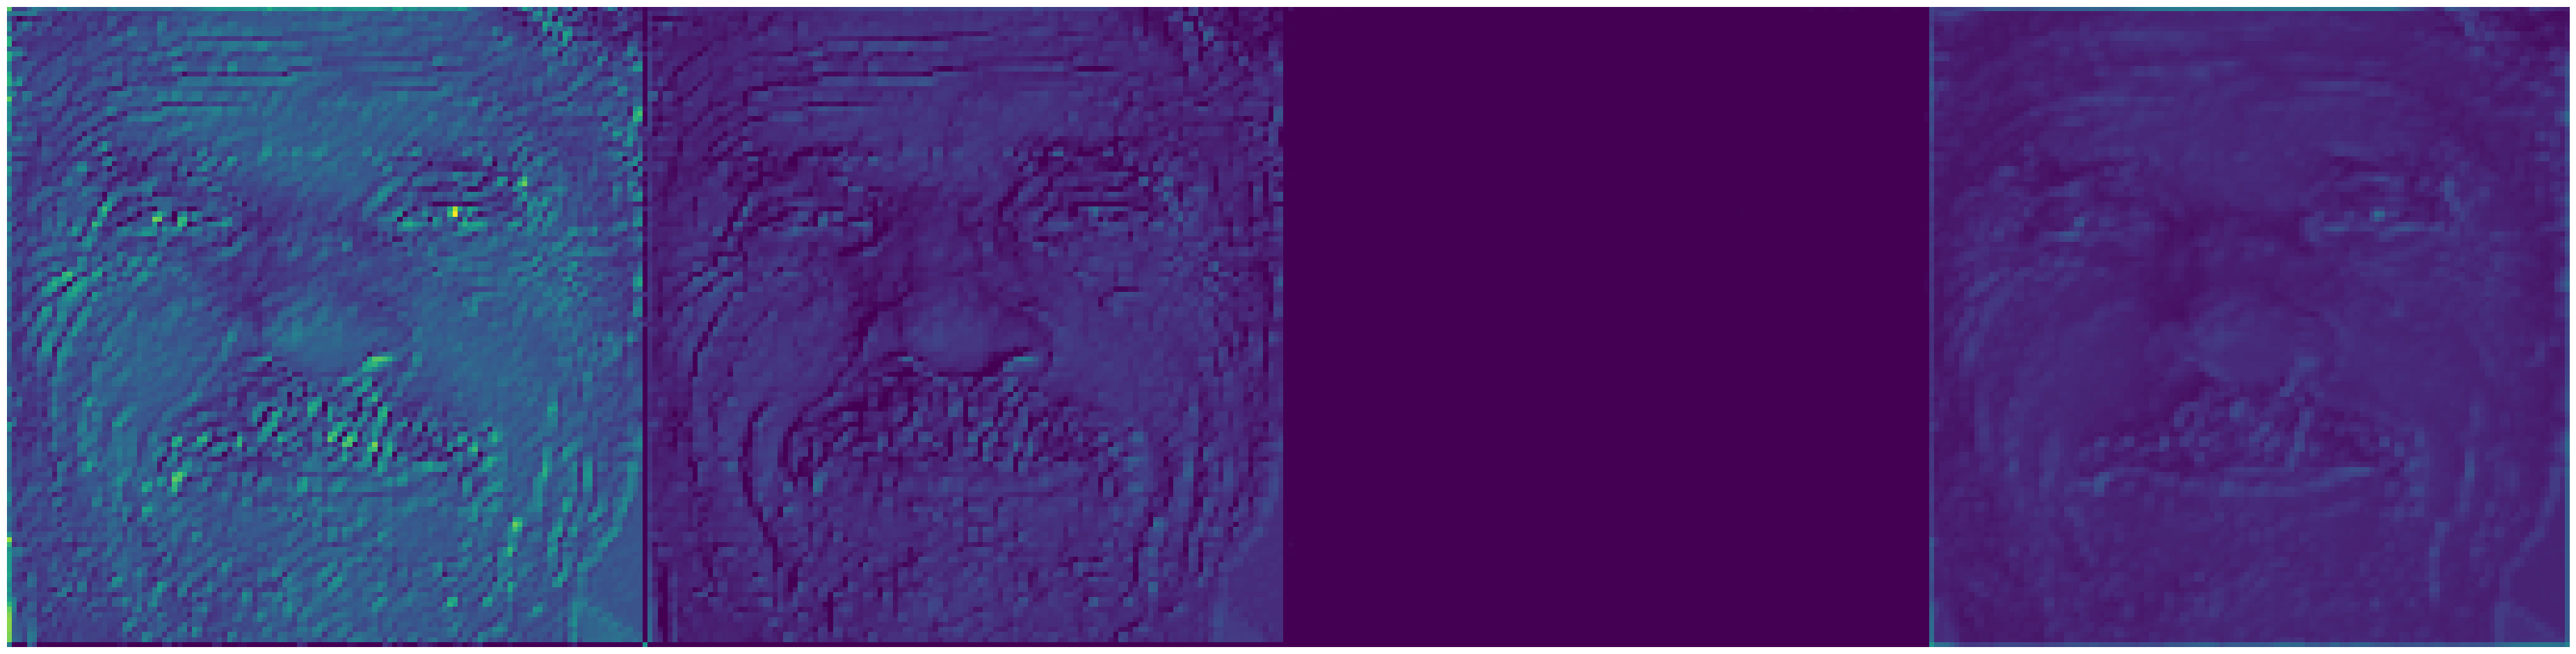

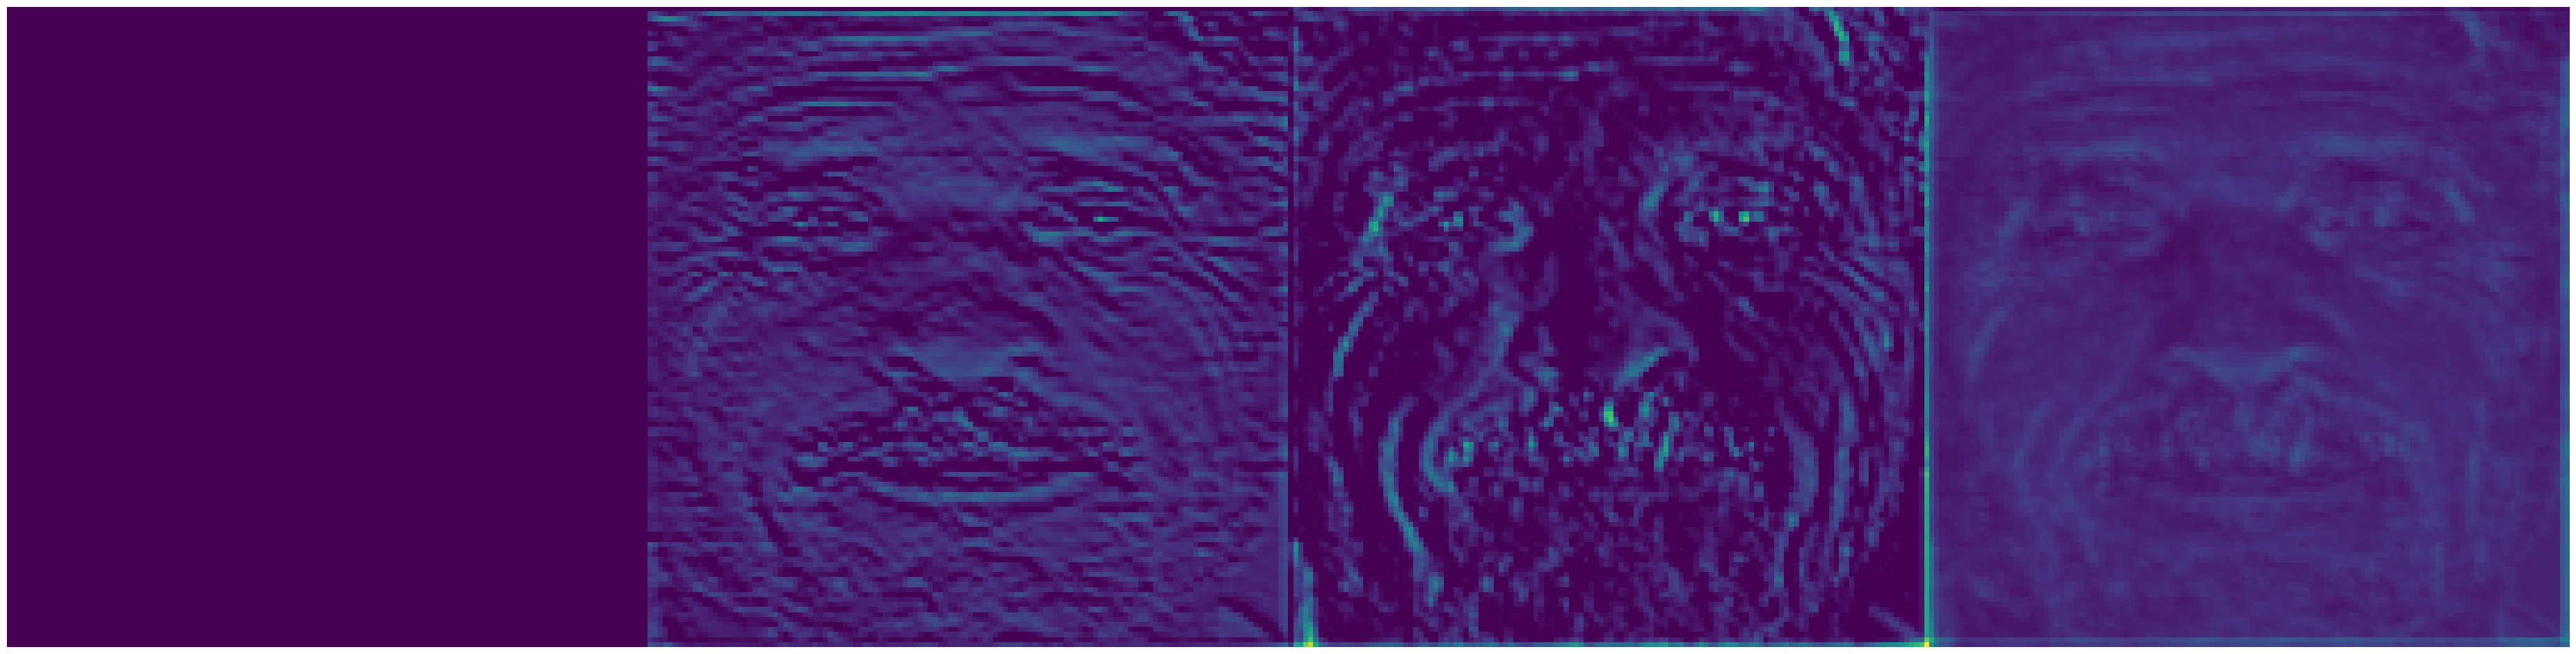

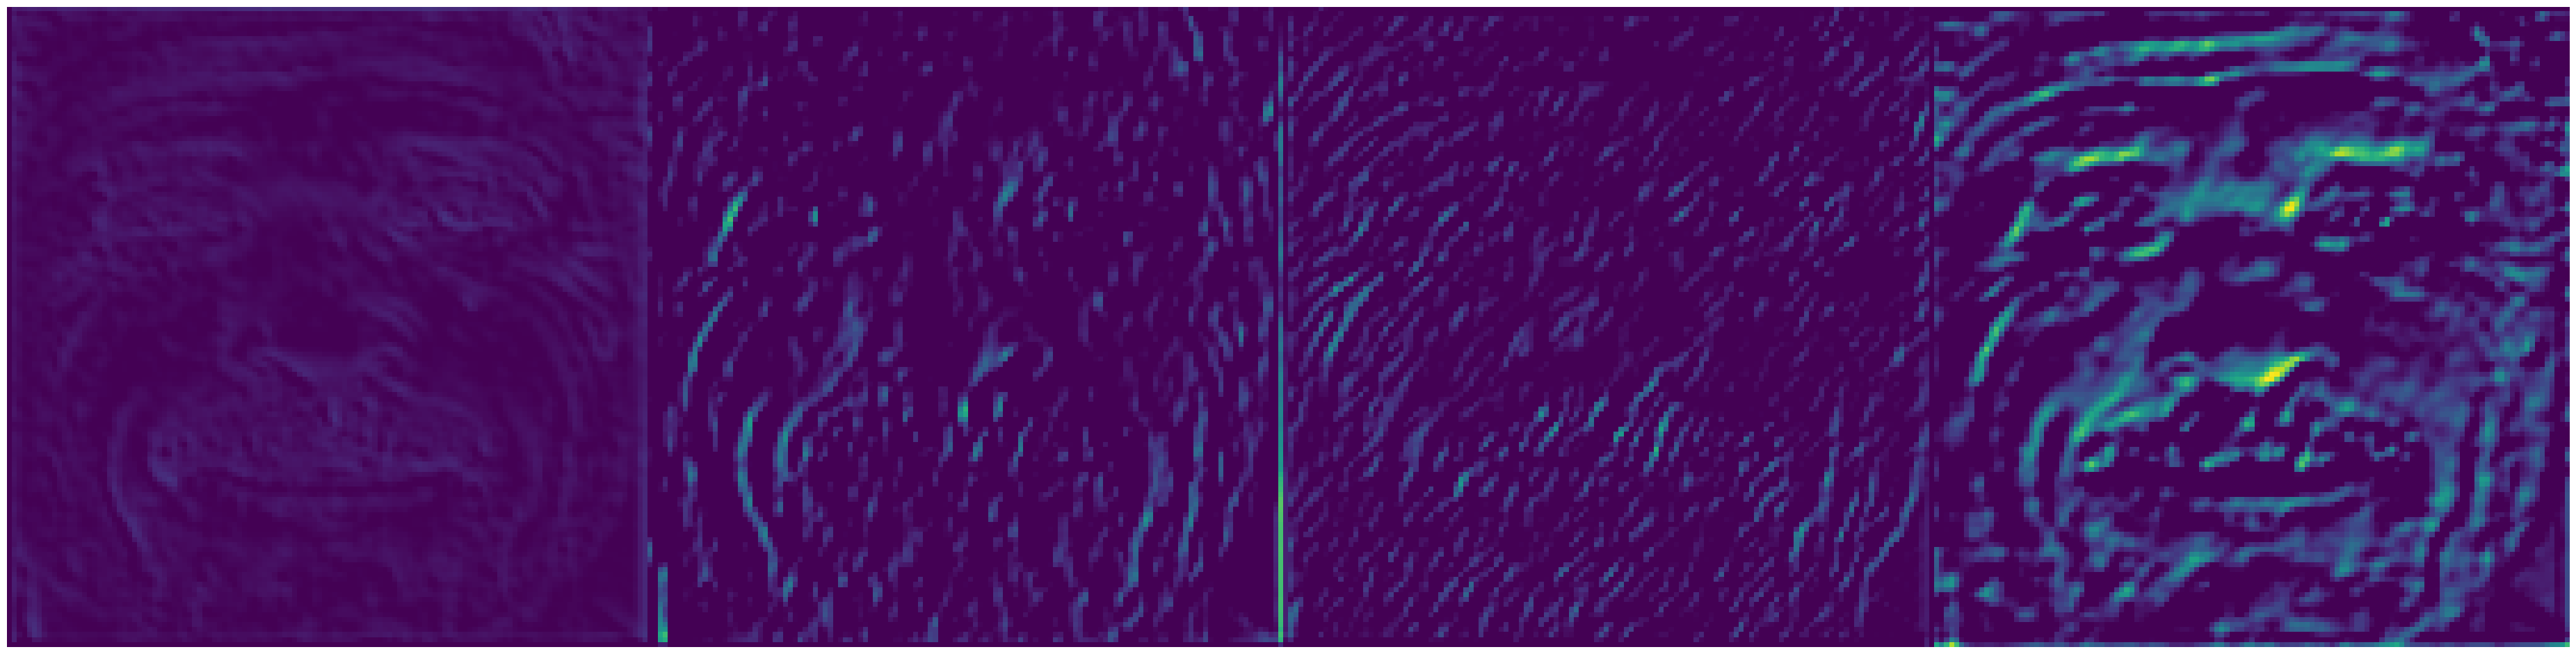

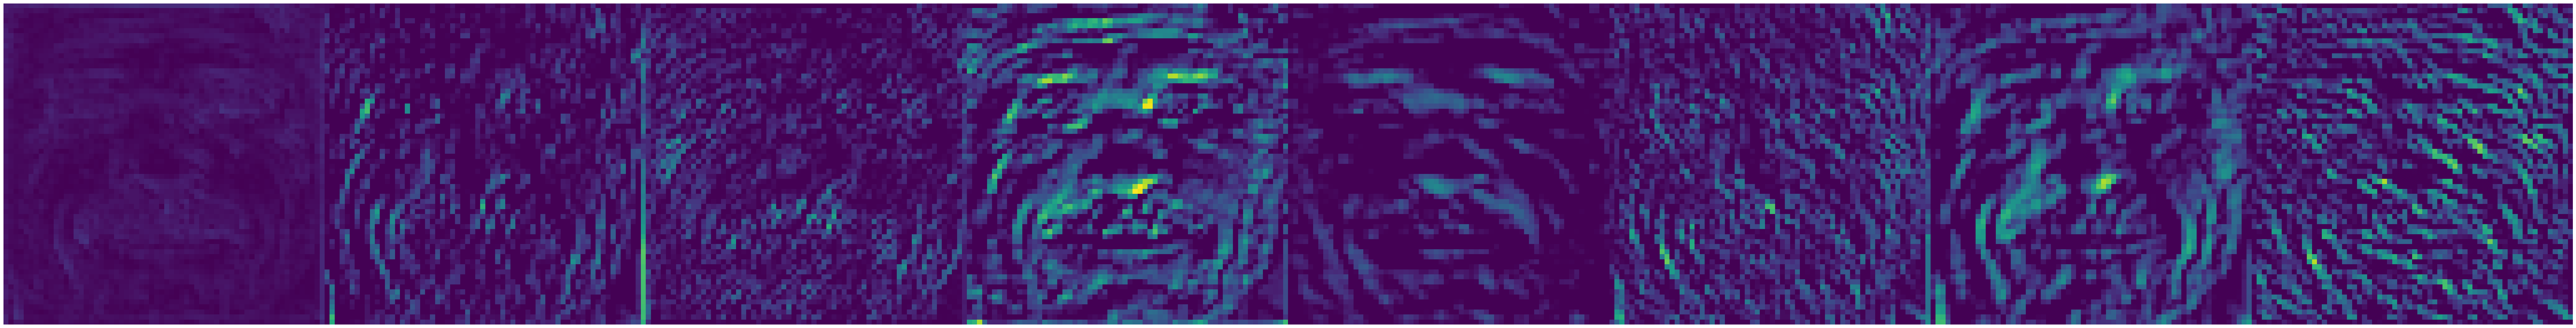

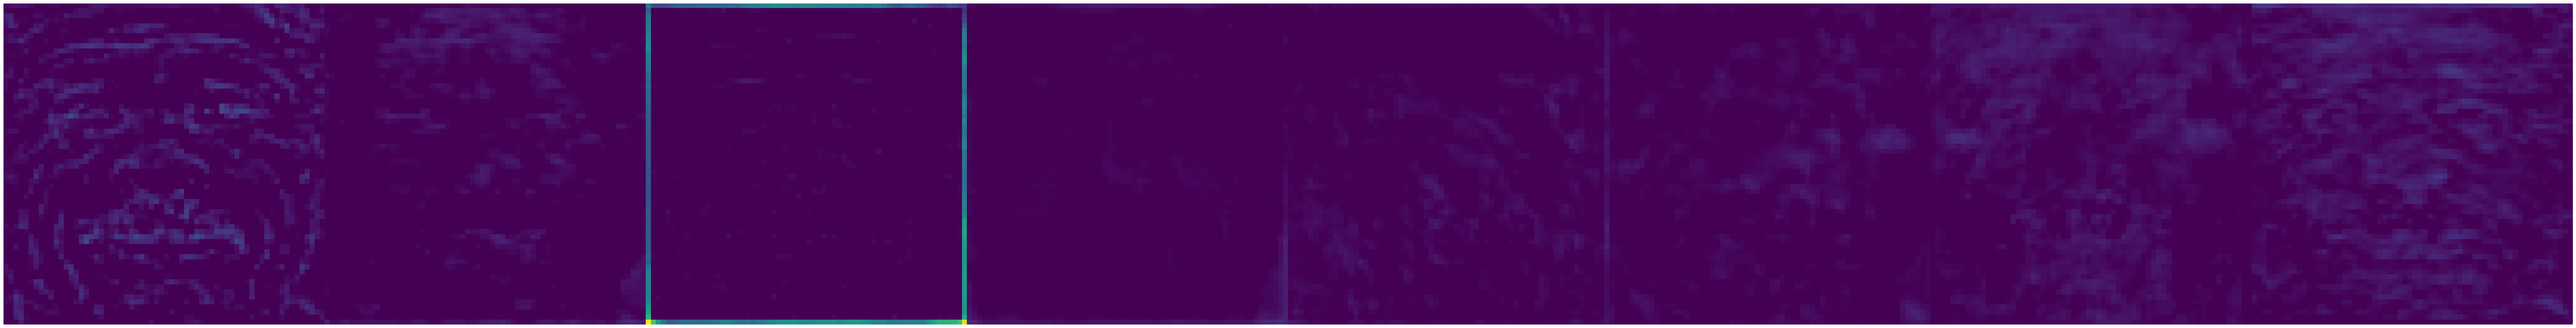

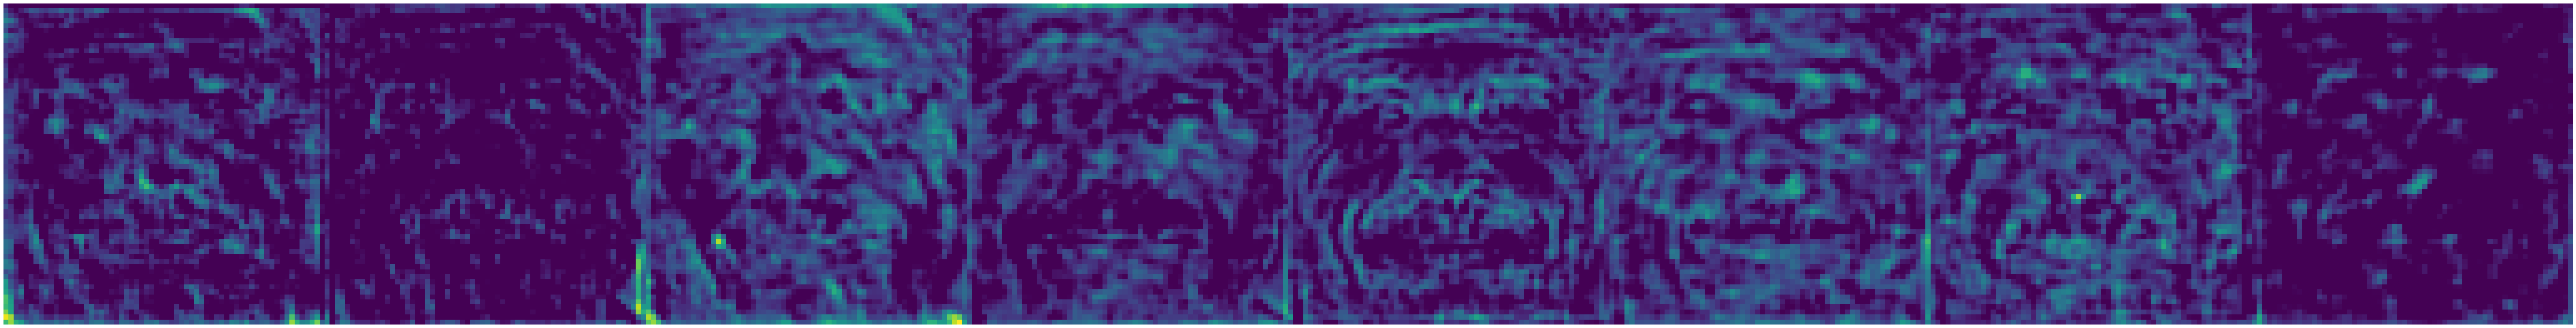

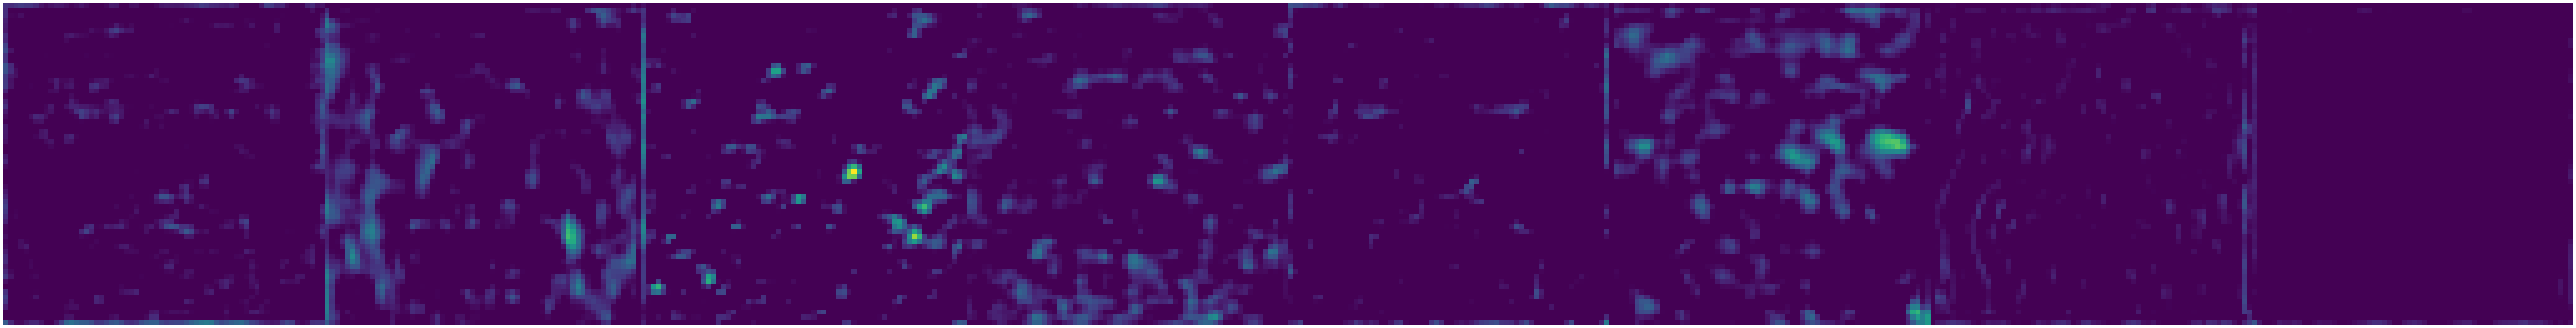

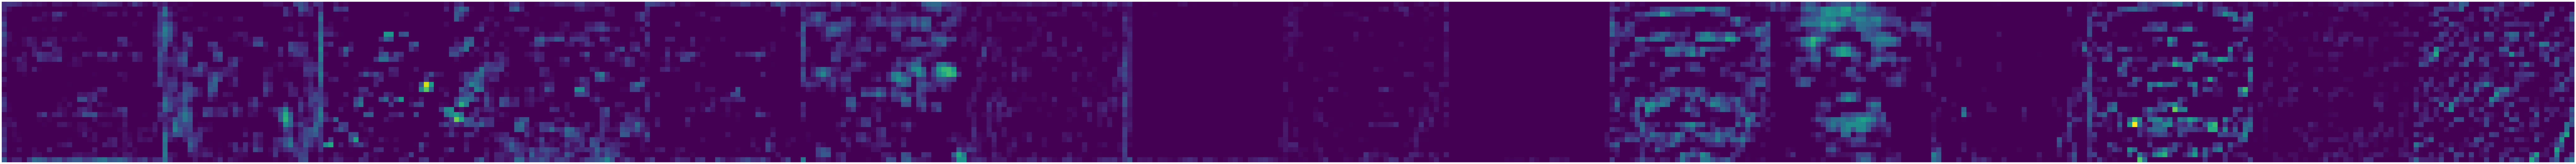

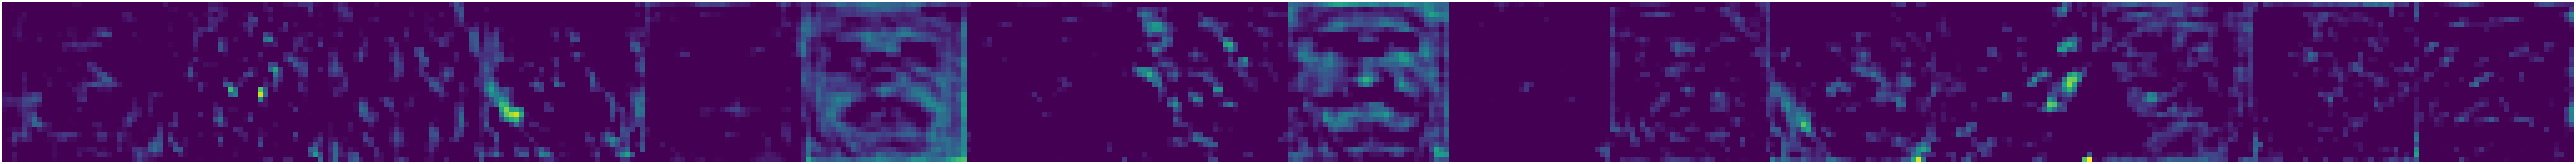

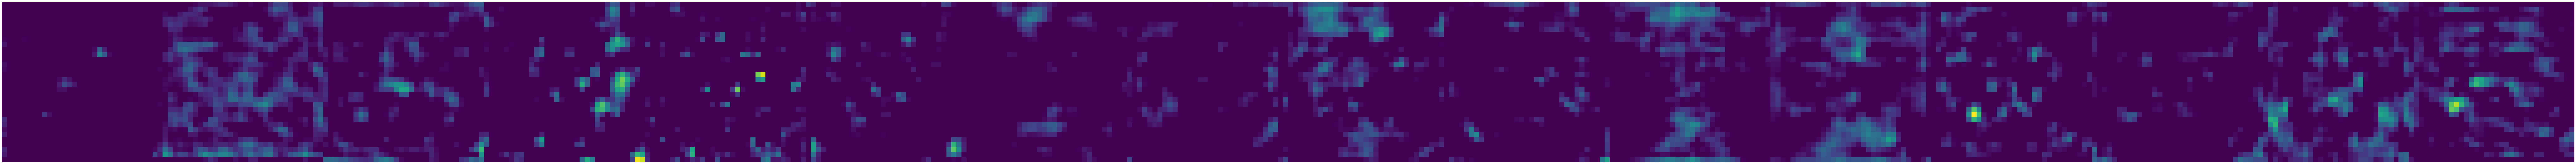

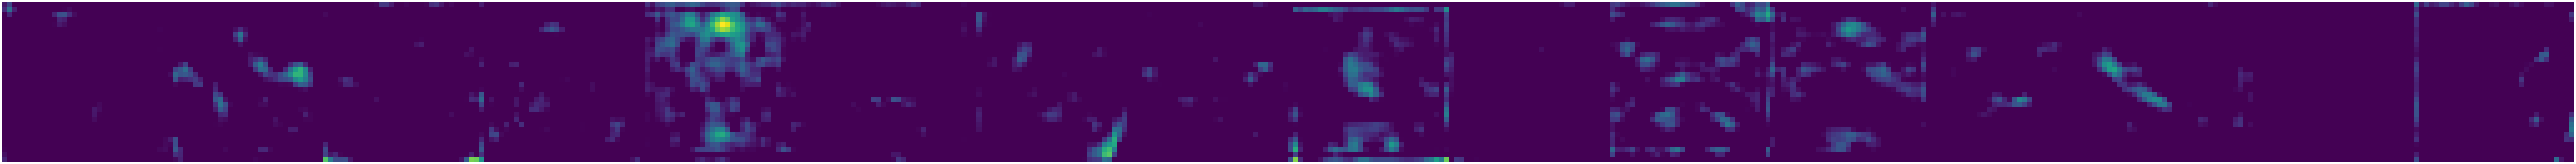

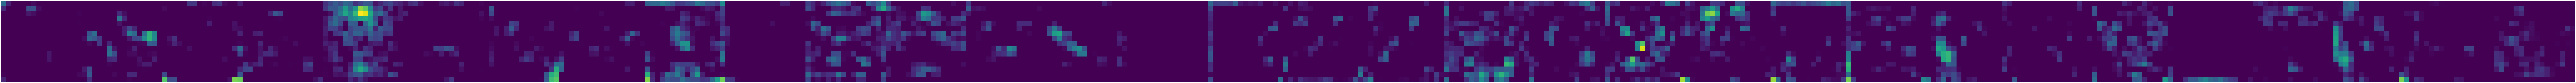

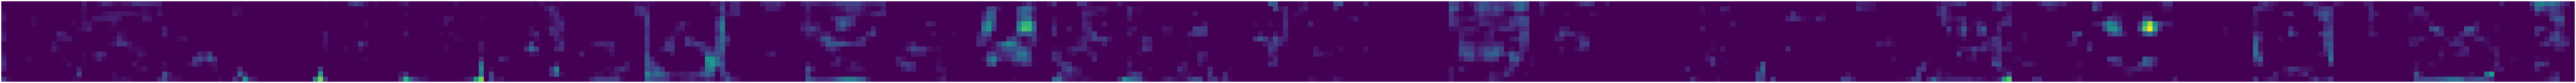

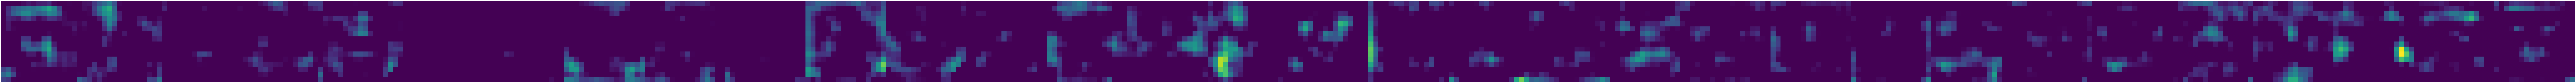

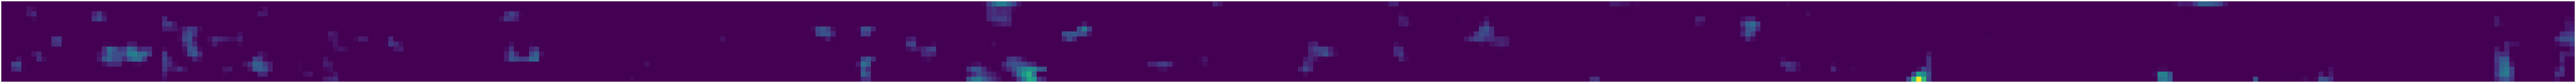

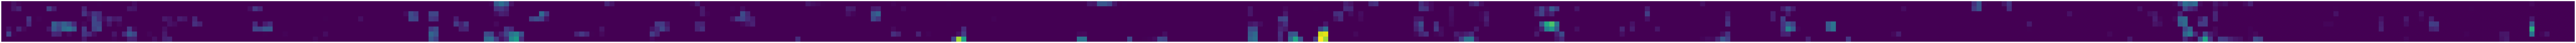

In [58]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256, 256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3] # index number of the shape since channels is in 3rd index
  joint_maps = np.ones((f_size, f_size * n_channels)) # plotting the channels side by side


  axs = plt.subplot(len(f_maps), 1, i + 1)

  for j in range(n_channels):
    joint_maps[:, f_size * j: f_size * (j+1)] = f_maps[i][..., j] # basically plotting side by side
    # first is 0: 256 (position : width), 256: 512, 512: 768 and so on
    # f_maps[i][..., j] this fills in the images in the spot created
  plt.imshow(joint_maps[:, 0: 512 ])
  plt.axis('off')


<p>This is how a Model Visualizes the image passed different ways in between the layers, the feature maps generated are quite important to check how your model extracts features which in turns can improve in finetuning and debugging, In the image above the 18 Layers and their workings are shown(subject to layers customization)</p>

# Training

In [145]:
# from keras.callbacks import ModelCheckpoint


# checkpoint_callback = ModelCheckpoint(
#     'best_weights', monitor='val_accuracy', mode= 'max', verbose= 1, save_best_only= True
# )

In [146]:
# when the dataset is in vector mode or categorical mode [0, 1, 0] belongs to class 2 for instance
loss_function = CategoricalCrossentropy()
# incase our dataset mode is int where labels are [0, 1, 2]then we use:
# loss_function = SparseCategoricalCrossentropy()

In [147]:
metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]


In [159]:
model.compile(
    optimizer =  tf.keras.optimizers.legacy.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [160]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,

)

Epoch 1/20
213/213 [==============================] - 96s 375ms/step - loss: 0.7886 - accuracy: 0.6982 - top_k_accuracy: 0.8978 - val_loss: 0.6045 - val_accuracy: 0.7507 - val_top_k_accuracy: 0.9280
Epoch 2/20
213/213 [==============================] - 76s 357ms/step - loss: 0.5607 - accuracy: 0.7688 - top_k_accuracy: 0.9401 - val_loss: 0.6333 - val_accuracy: 0.7695 - val_top_k_accuracy: 0.9359
Epoch 3/20
213/213 [==============================] - 76s 357ms/step - loss: 0.4792 - accuracy: 0.8056 - top_k_accuracy: 0.9494 - val_loss: 0.5304 - val_accuracy: 0.7849 - val_top_k_accuracy: 0.9276
Epoch 4/20
213/213 [==============================] - 76s 357ms/step - loss: 0.4270 - accuracy: 0.8281 - top_k_accuracy: 0.9540 - val_loss: 0.5262 - val_accuracy: 0.7893 - val_top_k_accuracy: 0.9438
Epoch 5/20
213/213 [==============================] - 76s 357ms/step - loss: 0.3846 - accuracy: 0.8412 - top_k_accuracy: 0.9618 - val_loss: 0.4795 - val_accuracy: 0.8126 - val_top_k_accuracy: 0.9447
Epoch

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [168]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/EfficientNetB5-Emotion_model/trained_weights.h5')

In [171]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/116802.jpg')

desired_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])
resized_image = cv2.resize(test_image, desired_size)

# Convert the resized image to a tensor
image_tensor = tf.constant(resized_image, dtype=tf.float32)

# Expand the dimensions to create a batch with a single image
image_tensor = tf.expand_dims(image_tensor, axis=0)

# Make predictions
preds = model.predict(image_tensor)

1/1 [==============================] - 0s 34ms/step


In [172]:
print(preds)
np.argmax(preds[0])

[[9.9598819e-01 3.7058245e-03 3.0594011e-04]]


0

In [178]:
last_conv_layer_name = 'top_activation'
last_conv_layer = model.get_layer(last_conv_layer_name) # basically backpropogating to get the gradient of the classification for Grad_cam
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
last_conv_layer_model.summary()

In [183]:
classifier_layer_names = [
    'global_average_pooling2d_10',
    'dense_27',
    'dense_28',
    'dense_29'
]

In [184]:
classifier_input = Input(shape = (8, 8, 2048)) # the shape of the output of last_conv_layer_model
x = classifier_input
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
  classifier_model = Model(classifier_input, x)

In [186]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(image_tensor)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output) # step tp calculate gradient by back propogation and obtained the gradient calue with respect to feature maps

In [187]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [188]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

In [190]:
print(pooled_grads.shape) # changed to vector or a weight(weighted_sum) for the next step which is heatmap generation

(2048,)


In [193]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]


In [194]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


In [195]:
heatmap = np.sum(last_conv_layer_output, axis = -1)

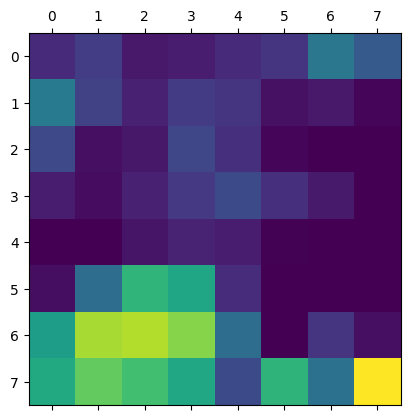

In [196]:
heatmap = tf.nn.relu(heatmap)
plt.matshow(heatmap)

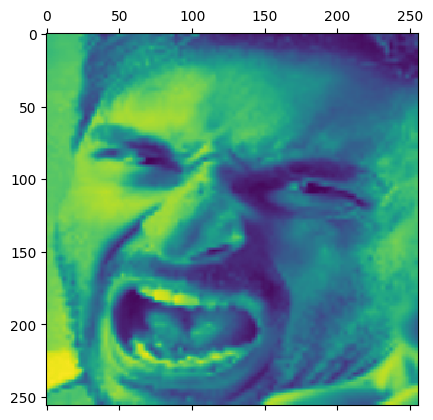

In [201]:
resized_heatmap = cv2.resize(np.array(heatmap), (256, 256))
plt.matshow(resized_heatmap * 255 + image_tensor[0, :, :, 0] / 255)

This a is how a Gradcam is implemented

# Model loss and accuracy Visualization

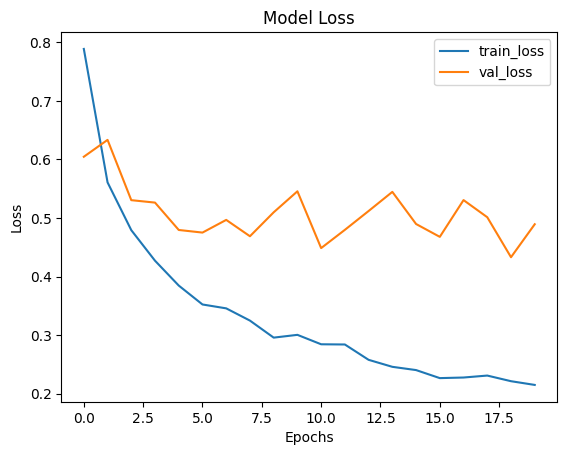

In [161]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

Since the model was pretrained so data augmentation and cutmix was causing the val loss to be lower than the train loss, which was a bad sign so removed the cutmix layer and trained it again to obtain a better model

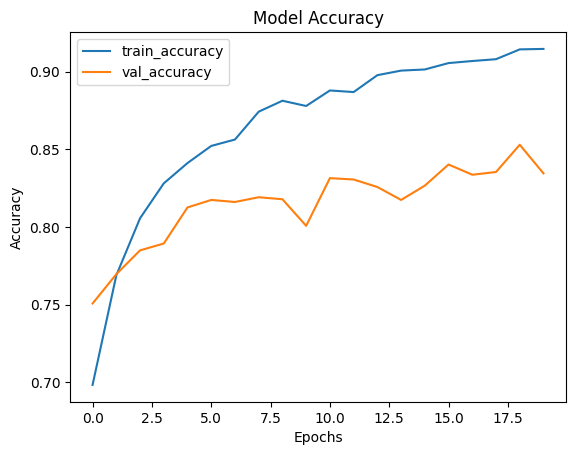

In [162]:
# the accuracy is low due to less epoch as compared to before which was trained for 60 epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [163]:
model.evaluate(validation_dataset)

72/72 [==============================] - 18s 241ms/step - loss: 0.4893 - accuracy: 0.8345 - top_k_accuracy: 0.9526


[0.4892768859863281, 0.8345039486885071, 0.9525899887084961]

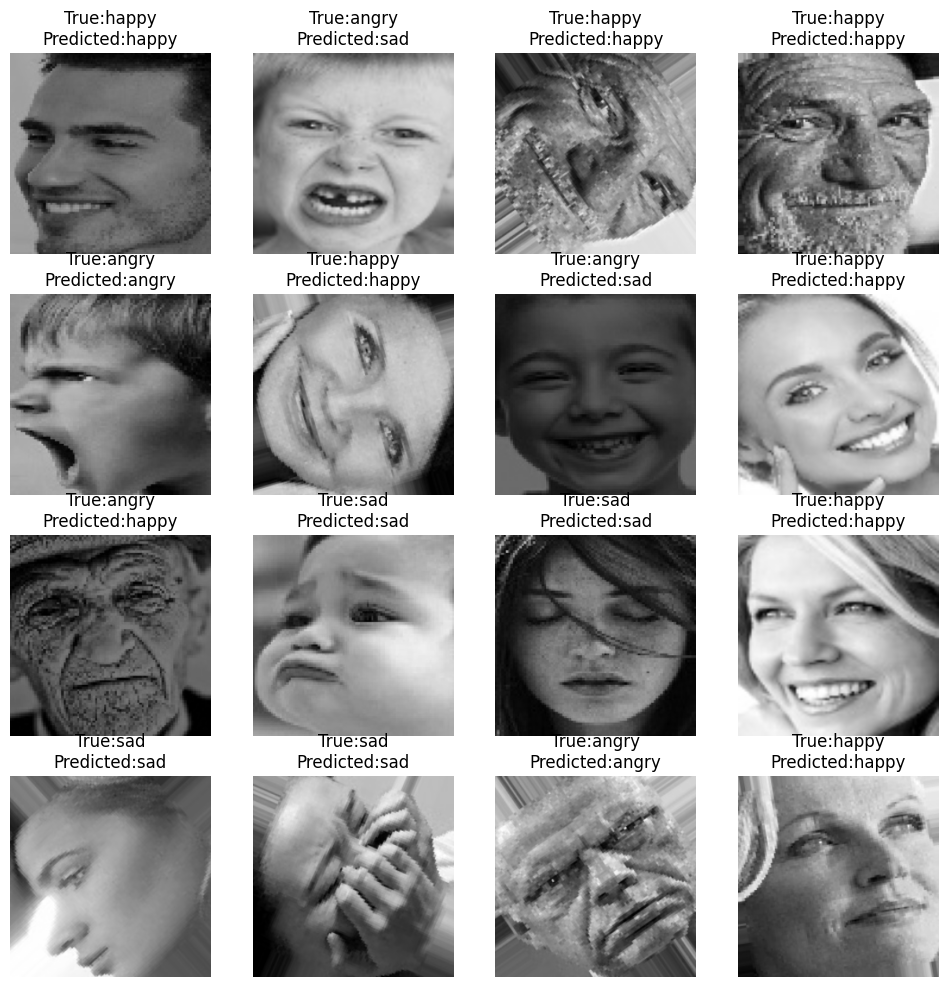

In [164]:
plt.figure(figsize = (12, 12))
for images, labels in validation_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    predicted_index = tf.argmax(model(tf.expand_dims(images[i], axis = 0)).numpy()[0])
    plt.title('True:' + CLASS_NAMES[label_index] + '\n' + 'Predicted:' + CLASS_NAMES[predicted_index])
    ax.axis('off')

In [165]:
13/16 # accuracy rate

0.8125

# Testing

In [ ]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg_brightness_2.jpg')

desired_size = (256, 256)
resized_image = cv2.resize(test_image, desired_size)

# Convert the resized image to a tensor
image_tensor = tf.constant(resized_image, dtype=tf.float32)

# Expand the dimensions to create a batch with a single image
image_tensor = tf.expand_dims(image_tensor, axis=0)

# Make predictions
predictions = model.predict(image_tensor)

# Find the predicted class
predicted_class_index = tf.argmax(predictions, axis=-1).numpy()[0]

# Print the class label based on the index
print(CLASS_NAMES[predicted_class_index]) # printing alongwith class since our dataset was preset with vector mode

1/1 [==============================] - 4s 4s/step
happy


# Confusion matrix

In [173]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(model(im))
    labels.append(label.numpy())


In [174]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 0 ... 0 2 2]
[1 1 0 ... 0 2 2]


In [175]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
label = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[397  49  69]
 [ 41 885  80]
 [ 58  80 619]]


Text(0.5, 58.7222222222222, 'Predicted')

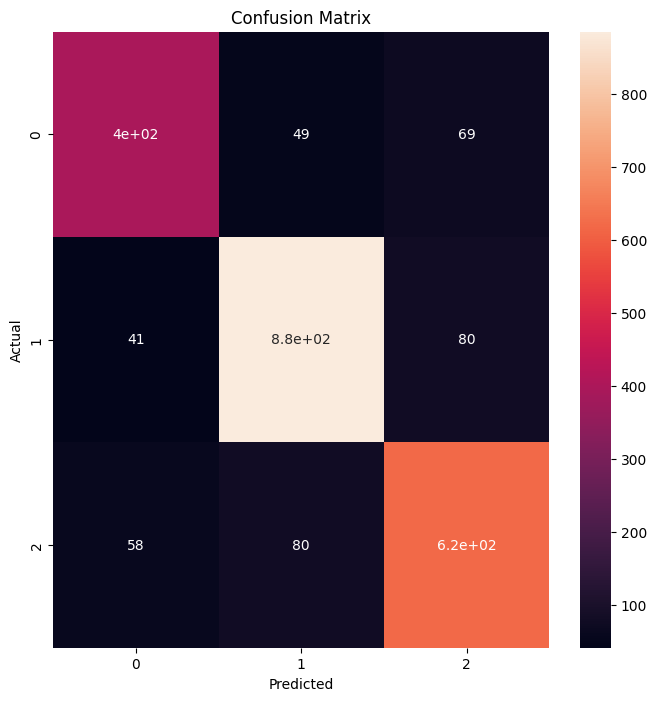

In [176]:
cm = confusion_matrix(label , pred)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')